# Store Sales - Time Series Forecasting
*Use machine learning to predict grocery sales*

In [373]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="muted")


### Data collection

In [407]:
df_train = pd.read_csv(
    "./data/train.csv", parse_dates=["date"], infer_datetime_format=True
)
df_test = pd.read_csv(
    "./data/test.csv", parse_dates=["date"], infer_datetime_format=True
)
test_id = df_test["id"]
pd.concat([df_train.head(2), df_train.tail(2)])

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.0,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.0,0


In [375]:
df_train.shape

(3000888, 6)

In [408]:
df_holidays = pd.read_csv(
    "./data/holidays_events.csv", parse_dates=["date"], infer_datetime_format=True
)
pd.concat([df_holidays.head(2), df_holidays.tail(2)])

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [377]:
df_stores = pd.read_csv("./data/stores.csv")
pd.concat([df_stores.head(2), df_stores.tail(2)])

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
52,53,Manta,Manabi,D,13
53,54,El Carmen,Manabi,C,3


In [409]:
df_oil = pd.read_csv("./data/oil.csv", parse_dates=["date"], infer_datetime_format=True)
pd.concat([df_oil.head(5), df_oil.tail(5)])

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


In [410]:
df_txns = pd.read_csv(
    "./data/transactions.csv", parse_dates=["date"], infer_datetime_format=True
)
pd.concat([df_txns.head(2), df_txns.tail(2)])

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
83486,2017-08-15,53,932
83487,2017-08-15,54,802


### EDA

#### Check nulls

In [380]:
def show_missing_data(df, df_name):
    """
    Display number and percentage of columns with any missing value
    """
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (
        ((df.isnull().sum() / df.isnull().count()) * 100)
        .sort_values(ascending=False)
        .round(2)
    )
    missing_data = pd.concat([total, percent], axis=1, keys=["# missing", "% missing"])
    
    if missing_data["# missing"].max() > 0:
        print(f'`{df_name}` has null values:')
        print(missing_data[missing_data["# missing"] > 0])
    else:
        print(f'`{df_name}` does not have null values')

In [381]:
show_missing_data(df_train, 'df_train')
show_missing_data(df_test, 'df_test')
show_missing_data(df_txns, 'df_txns')
show_missing_data(df_holidays, 'df_holidays')
show_missing_data(df_oil, 'df_oil')

`df_train` does not have null values
`df_test` does not have null values
`df_txns` does not have null values
`df_holidays` does not have null values
`df_oil` has null values:
            # missing  % missing
dcoilwtico         43       3.53


### Data cleaning & Preprocessing

#### Manage nulls

In [382]:
def fill_missing_with_surrounding_mean(df, target_column, min_periods=2, decimals=2):
    """
    fill null values on field `target_column` with their surrounding `min_periods` peers
    """
    # Calculate the rolling mean with the specified minimum number of periods
    rolling_mean = (
        df[target_column]
        .rolling(window=min_periods * 2 + 1, min_periods=min_periods, center=True)
        .mean()
    )

    # Round the rolling mean to the specified number of decimal places
    rounded_mean = rolling_mean.round(decimals)

    # Fill missing values in the target column with the rolling mean
    df[target_column].fillna(rounded_mean, inplace=True)

    return df

# Alternatively:
# df_oil['dcoilwtico'].fillna(method='backfill', inplace=True)

### Process dataset

In [383]:
df_oil = fill_missing_with_surrounding_mean(df_oil, 'dcoilwtico', 1)
show_missing_data(df_oil, 'df_oil')

`df_oil` does not have null values


### EDA

In [384]:
df_train['date'] = pd.to_datetime(df_train['date'])

<Axes: xlabel='sales', ylabel='Count'>

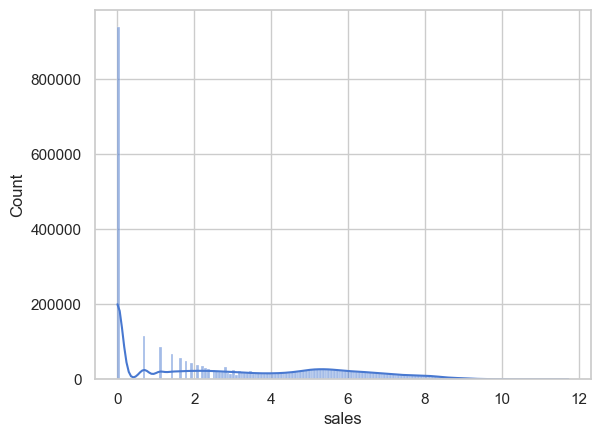

In [385]:
sns.histplot(np.log1p(df_train['sales']), kde=True)

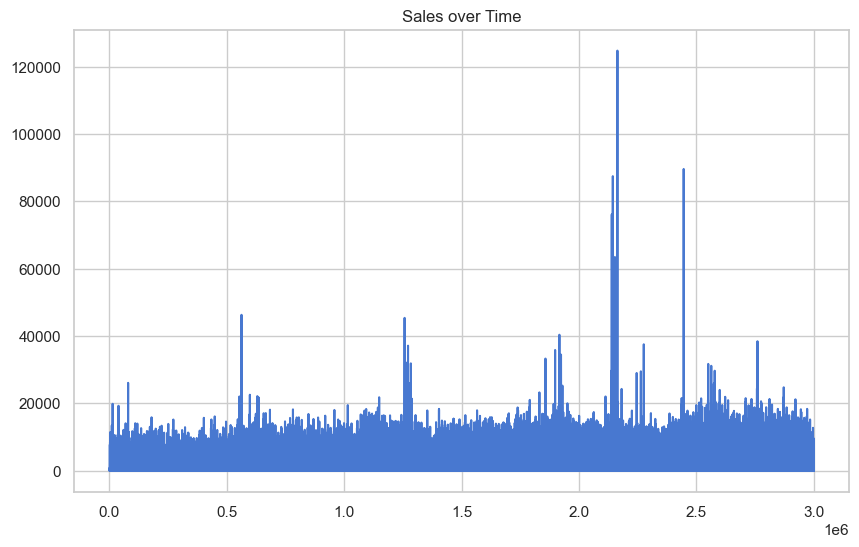

In [386]:
df_train['sales'].plot(figsize=(10, 6))
plt.title('Sales over Time')
plt.show()

<Axes: xlabel='date', ylabel='dcoilwtico'>

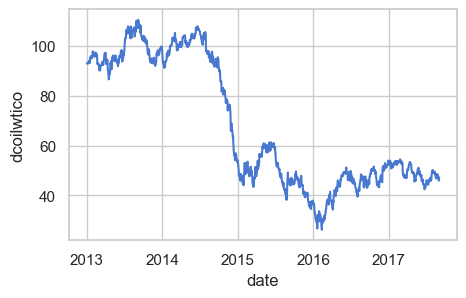

In [387]:
plt.figure(figsize=(5,3))
sns.lineplot(data=df_oil, x='date', y='dcoilwtico')

### Feature engineering

In [388]:
# TBD
df_train['sales'] = np.log1p(df_train['sales'])

In [389]:
def lag_features(df, lags):
    for lag in lags:
        # Create column 'sales_t-lag' by taking previous values ​​of column 'sales' based on columns 'store_nbr' and 'family'
        df[f"sales_t-{lag}"] = df.groupby(["store_nbr", "family"])["sales"].transform(
            lambda x: x.shift(lag)
        )
    return df

In [390]:
def fill_na(df):
    # Fill missing values in the 'holiday_type' column with 'Common'.
    df["holiday_type"] = df["holiday_type"].fillna("Common")
    # Fill missing values in the 'locale' column with 'Common'.
    df["locale"] = df["locale"].fillna("Common")
    # Fill missing values in the 'description' column with 'Unknown'.
    df["description"] = df["description"].fillna("Unknown")
    # Fill missing values in the 'transferred' column with False.
    df["transferred"] = df["transferred"].fillna(False)
    # Fill missing values in the 'dcoilwtico' column using the backfill method.
    # df["dcoilwtico"] = df["dcoilwtico"].fillna(method="backfill")
    return df

In [391]:
def merge_data(df):
    df = (
        df.merge(df_stores, left_on="store_nbr", right_on="store_nbr", how="left")
        .rename(columns={"type": "store_type"})
        .merge(
            df_txns,
            left_on=["date", "store_nbr"],
            right_on=["date", "store_nbr"],
            how="left",
        )
        .merge(df_holidays, left_on="date", right_on="date", how="left")
        .drop_duplicates(subset="id")
        .rename(columns={"type": "holiday_type"})
        .merge(df_oil, left_on="date", right_on="date", how="left")
    )
    return df

In [392]:
def create_date_features(df):
    df["month"] = df["date"].dt.month
    df["day_of_month"] = df["date"].dt.day
    df["day_of_year"] = df["date"].dt.dayofyear
    df["week_of_year"] = df["date"].dt.isocalendar().week
    df["day_of_week"] = df["date"].dt.dayofweek
    df["year"] = df["date"].dt.year
    return df

In [393]:
def random_noise(dataframe):
    """
    Generate random noise with a normal distribution (mean=0, std=2)
    matching the length of the dataframe.
    """
    return np.random.normal(scale=2.0, size=(len(dataframe),))

In [394]:
def roll_mean_features(dataframe, windows):
    """
    Calculate rolling mean with triangular window and custom
    noise for 'sales' within 'store_nbr' and 'family' groups.
    """
    def add_noise(x):
        return x + np.random.normal(size=len(x))

    for window in windows:
        dataframe["sales_roll_mean_" + str(window)] = dataframe.groupby(
            ["store_nbr", "family"]
        )["sales"].transform(
            lambda x: x.shift(16)
            .rolling(window=window, min_periods=7, win_type="triang")
            .mean()
        )
        dataframe["sales_roll_mean_" + str(window)] = dataframe.groupby(
            ["store_nbr", "family"]
        )["sales_roll_mean_" + str(window)].transform(add_noise)
    return dataframe

In [395]:
def ewma_features(dataframe, alphas, lags):
    """
    Create Exponentially Weighted Moving Average (EWMA) features for 'sales'
    with specified alphas and lags, grouped by 'store_nbr' and 'family'.
    """
    for alpha in alphas:
        for lag in lags:
            feature_name = (
                "sales_ewm_alpha_" + str(alpha).replace(".", "") + "_lag_" + str(lag)
            )
            dataframe[feature_name] = dataframe.groupby(["store_nbr", "family"])[
                "sales"
            ].transform(lambda x: x.shift(lag).ewm(alpha=alpha, min_periods=1).mean())
    return dataframe

In [396]:
col = [
    "date",
    "store_nbr",
    "family",
    "sales",
    "onpromotion",
    "cluster",
    "holiday_type",
    "locale",
    "description",
    "transferred",
    "dcoilwtico",
]

In [397]:
df_all = pd.concat([df_train, df_test], axis=0)
df_all = merge_data(df_all)
df_all = fill_na(df_all)
df_all = create_date_features(df_all)
df_all = lag_features(
    df_all, lags=[*range(1, 16), 16, 17, 18, 19, 20, 21, 22, 30, 31, 90, 180, 364]
)
df_all = roll_mean_features(df_all, [16, 17, 18, 30])
df_all = df_all[col]

In [398]:
alphas = [0.95, 0.9, 0.8, 0.5]
lags =[1, 7,30]
all_df = ewma_features(df_all, alphas, lags)

In [399]:
df_all["store_nbr"] = df_all["store_nbr"].astype("category")
df_all["family"] = df_all["family"].astype("category")
df_all["store_nbr"] = df_all["store_nbr"].astype("category")
df_all["cluster"] = df_all["cluster"].astype("category")
df_all["family"] = df_all["family"].astype("category")
df_all["holiday_type"] = df_all["holiday_type"].astype("category")
df_all["locale"] = df_all["locale"].astype("category")
df_all["description"] = df_all["description"].astype("category")

In [400]:
df_all.head(3)

,date,store_nbr,family,sales,onpromotion,cluster,holiday_type,locale,description,transferred,...,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_09_lag_1,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30
0,2013-01-01,1,AUTOMOTIVE,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01,1,BABY CARE,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01,1,BEAUTY,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [401]:
df_all = df_all[df_all['date'] > '2013-12-31']
X = df_all[df_all['date'] <= '2017-08-15'].drop('date', axis=1)
X_test = df_all[df_all['date'] > '2017-08-15'].drop('date', axis=1)

In [402]:
corr = X.select_dtypes(include=['number']).corr()
corr["sales"].sort_values(ascending=False)

sales                         1.000000
sales_ewm_alpha_05_lag_1      0.973090
sales_ewm_alpha_08_lag_1      0.968657
sales_ewm_alpha_05_lag_7      0.966604
sales_ewm_alpha_09_lag_1      0.966508
sales_ewm_alpha_095_lag_1     0.965262
sales_ewm_alpha_08_lag_7      0.964625
sales_ewm_alpha_09_lag_7      0.963186
sales_ewm_alpha_095_lag_7     0.962281
sales_ewm_alpha_05_lag_30     0.923159
sales_ewm_alpha_08_lag_30     0.916762
sales_ewm_alpha_09_lag_30     0.914276
sales_ewm_alpha_095_lag_30    0.912902
onpromotion                   0.358192
dcoilwtico                   -0.115467
Name: sales, dtype: float64

In [403]:
y = X['sales']
X = X.drop(['sales'], axis=1)
X_test = X_test.drop(['sales'], axis=1)

### kind of Model building

In [404]:
X

,store_nbr,family,onpromotion,cluster,holiday_type,locale,description,transferred,dcoilwtico,sales_ewm_alpha_095_lag_1,...,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_09_lag_1,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30
648648,1,AUTOMOTIVE,0,13,Holiday,National,Primer dia del ano,False,96.66,1.076809,...,0.001735,1.052769,0.687990,0.006972,1.002909,0.679233,0.028343,0.912106,0.700663,0.191516
648649,1,BABY CARE,0,13,Holiday,National,Primer dia del ano,False,96.66,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
648650,1,BEAUTY,0,13,Holiday,National,Primer dia del ano,False,96.66,0.724470,...,0.001735,0.749605,1.100832,0.006969,0.783885,1.105052,0.028281,0.806839,1.090060,0.192592
648651,1,BEVERAGES,0,13,Holiday,National,Primer dia del ano,False,96.66,6.739959,...,6.109605,6.739162,7.140417,6.150354,6.722928,7.141227,6.230319,6.635299,7.108696,6.454561
648652,1,BOOKS,0,13,Holiday,National,Primer dia del ano,False,96.66,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,9,POULTRY,0,6,Holiday,Local,Fundacion de Riobamba,False,47.57,5.669041,...,6.344168,5.687419,5.911228,6.337646,5.724007,5.943887,6.320788,5.829966,6.062661,6.230597
3000884,9,PREPARED FOODS,1,6,Holiday,Local,Fundacion de Riobamba,False,47.57,4.742433,...,4.849691,4.739830,4.744327,4.854172,4.737019,4.757764,4.858467,4.742214,4.803638,4.827482
3000885,9,PRODUCE,148,6,Holiday,Local,Fundacion de Riobamba,False,47.57,7.218382,...,7.613556,7.228438,7.710392,7.603325,7.245679,7.681609,7.578174,7.272816,7.593833,7.479115
3000886,9,SCHOOL AND OFFICE SUPPLIES,8,6,Holiday,Local,Fundacion de Riobamba,False,47.57,5.213257,...,0.052401,5.215194,5.129171,0.100564,5.213560,5.120861,0.188557,5.161940,5.098202,0.446829


In [405]:
y


648648     0.000000
648649     0.000000
648650     0.000000
648651     0.000000
648652     0.000000
             ...   
3000883    6.084802
3000884    5.046987
3000885    7.791824
3000886    4.804021
3000887    2.833213
Name: sales, Length: 2352240, dtype: float64